In [1]:
import tensorflow as tf
print("Num of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version: ", tf.__version__)

Num of GPUs Available:  4
TensorFlow version:  2.5.0


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
x = tf.random.uniform([3, 3])
x.device

'/job:localhost/replica:0/task:0/device:GPU:0'

In [5]:
print("Is the Tensor on CPU #0:  "),
print(x.device.endswith('CPU:0'))
print('')
print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is the Tensor on CPU #0:  
False

Is the Tensor on GPU #0:  
True


In [6]:
import time
def time_matadd(x):
  start = time.time()
  for loop in range(10):
      tf.add(x, x)
  result = time.time()-start
  print("Matrix addition (10 loops): {:0.2f}ms".format(1000*result))

def time_matmul(x):
  start = time.time()
  for loop in range(10):
      tf.matmul(x, x)
  result = time.time()-start
  print("Matrix multiplication (10 loops): {:0.2f}ms".format(1000*result))

In [7]:
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matadd(x)
  time_matmul(x)

On CPU:
Matrix addition (10 loops): 3.27ms
Matrix multiplication (10 loops): 127.77ms


In [8]:
import numpy as np
import pandas as pd

import pathlib
import shutil
import tempfile

In [9]:
!pip install tensorflow_hub
!pip install tensorflow_datasets
!pip install -q git+https://github.com/tensorflow/docs

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [10]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display
%matplotlib inline

import pathlib
import shutil
import tempfile
import os

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from sklearn.model_selection import train_test_split

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print('Number of GPUs :',len(tf.config.list_physical_devices('GPU')))

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.5.0
Hub version:  0.12.0
GPU is available
Number of GPUs : 4


In [11]:
if os.path.exists('dataset.pkl'):
    df = pd.read_pickle('dataset.pkl')
else:
    df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', 
             compression='zip', low_memory=False)
    df.to_pickle('dataset.pkl')
df.shape

(1306122, 3)

<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

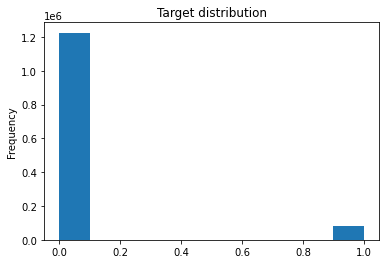

In [12]:
df['target'].plot(kind='hist', title='Target distribution')

In [13]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.1, stratify=df.target.values)
valid_df, _  = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)
print(train_df.shape, valid_df.shape)

(130612, 3) (1175, 3)


In [14]:
buffer_size = train_df.size
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values)).shuffle(buffer_size).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values)).batch(batch_size)

In [15]:
num = 0;
for x, y in train_dataset:
    num += 1
print(num)
train_df.shape[0]//256 + 1

511


511

In [16]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
embeding_size = 128
name_of_model = 'nnlm-en-dim128'

In [17]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype = tf.string, trainable=trainable)
    model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = tf.losses.BinaryCrossentropy(),
                metrics = [tf.metrics.BinaryAccuracy(name='accuracy')])
    history = model.fit(train_dataset,
                      epochs = 100,
                      validation_data=valid_dataset,
                      callbacks=[tfdocs.modeling.EpochDots(),
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                 tf.keras.callbacks.TensorBoard(logdir/name)],
                      verbose = 0
                      )
    return history

In [18]:
histories = {}

start = time.time()
histories[name_of_model] = train_and_evaluate_model(module_url, embed_size=embeding_size, name=name_of_model)
endt = time.time()-start
print("\n \n Time for {} ms".format(1000*endt))


Epoch: 0, accuracy:0.9364,  loss:0.2840,  val_accuracy:0.9379,  val_loss:0.1768,  
......................
 
 Time for 40582.165479660034 ms


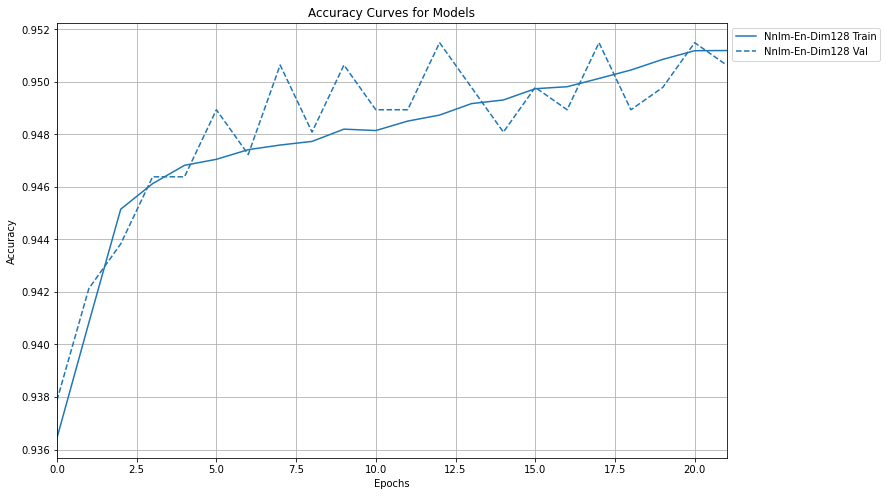

In [19]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

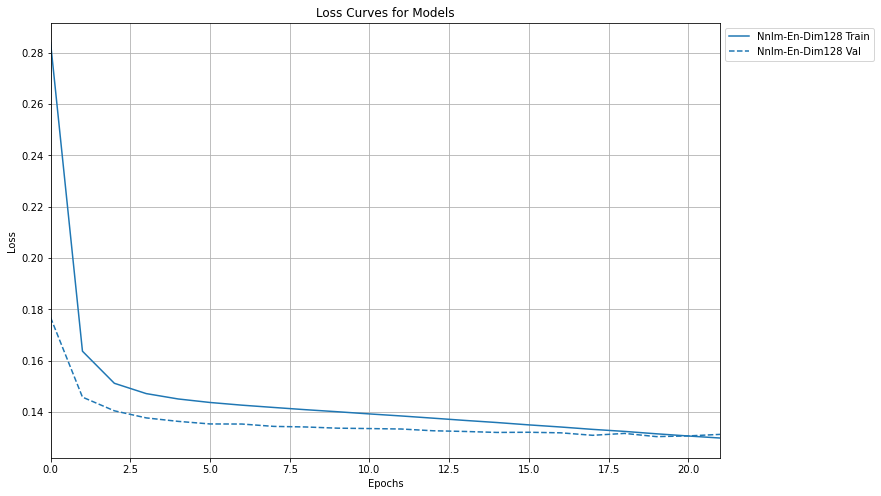

In [20]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

Distributed Training

In [21]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [22]:
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 4


In [23]:
buffer_size = train_df.size
batch_size_per_replica = 64
global_batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

In [24]:
train_dataset = (tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values))
                .shuffle(buffer_size)
                .batch(global_batch_size, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE)) #.shuffle(buffer_size)

valid_dataset = (tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))
                .batch(global_batch_size, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))

In [25]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype = tf.string, trainable=trainable)
    model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = tf.losses.BinaryCrossentropy(),
                metrics = [tf.metrics.BinaryAccuracy(name='accuracy')])
    history = model.fit(train_dataset, #train_df['question_text'], train_df['target'],
                      epochs = 100,
                      batch_size=32,
                      validation_data=valid_dataset, #(valid_df['question_text'], valid_df['target']),
                      callbacks=[tfdocs.modeling.EpochDots(),
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                 tf.keras.callbacks.TensorBoard(logdir/name)],
                      verbose = 0
                      )
    return history

In [26]:
with strategy.scope():
   start = time.time()
   histories['nnlm-en-dim128'] = train_and_evaluate_model(module_url, embed_size=128, name='nnlm-en-dim128')
   endt = time.time()-start
   print("\n \n Time for {} ms".format(1000*endt))

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1



Epoch: 0, accuracy:0.9374,  loss:0.2724,  val_accuracy:0.9385,  val_loss:0.1702,  
...................
 
 Time for 86904.81781959534 ms


In [27]:
buffer_size = train_df.size
batch_size_per_replica = 64
global_batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

train_dataset = (tf.data.Dataset.from_tensor_slices((train_df.question_text.values[...,None], train_df.target.values[...,None]))
                .shuffle(buffer_size)
                .batch(global_batch_size, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))

valid_dataset = (tf.data.Dataset.from_tensor_slices((valid_df.question_text.values[...,None], valid_df.target.values[...,None]))
                .batch(global_batch_size, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))

In [28]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
embeding_size = 128
name_of_model = 'nnlm-en-dim128/1'
def create_model(module_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_url, input_shape=[],
                               output_shape=[embed_size],dtype = tf.string, trainable=trainable)

    model = tf.keras.models.Sequential([hub_layer,
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.Dense(64, activation='relu'),
                                        tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

In [29]:
with strategy.scope():
# Set reduction to `none` so we can do the reduction afterwards and divide by
# global batch size.

    loss_object = tf.losses.BinaryCrossentropy(
        from_logits=False,
        reduction=tf.losses.Reduction.NONE)

    def compute_loss(labels, predictions):
        per_example_loss = loss_object(labels, predictions)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=global_batch_size)

    train_accuracy = tf.metrics.BinaryAccuracy(name='train_accuracy')
    valid_accuracy = tf.metrics.BinaryAccuracy(name='valid_accuracy')

    model = create_model(module_url, embed_size=embeding_size, name=name_of_model, trainable=False)
    optimizer = tf.optimizers.Adam()

In [30]:
def train_step(inputs):
    texts, labels = inputs

    with tf.GradientTape() as tape:
        predictions = model(texts, training=True)
        loss = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_accuracy.update_state(labels, predictions)
    return loss

def valid_step(inputs):
    texts, labels = inputs

    predictions = model(texts, training=False)
    v_loss = compute_loss(labels, predictions)

    valid_accuracy.update_state(labels, predictions)

    return v_loss

In [31]:
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
valid_dist_dataset = strategy.experimental_distribute_dataset(valid_dataset)

Without early stopping

In [32]:
epochs = 20
# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)

@tf.function
def distributed_valid_step(dataset_inputs):
    per_replica_losses = strategy.run(valid_step, args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)

history_df = pd.DataFrame(columns=['epochs', 'train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

start = time.time()
for epoch in range(epochs):
    # TRAIN LOOP
    total_loss = 0.0
    num_batches = 0

    for x in train_dist_dataset:
        total_loss += distributed_train_step(x)
        num_batches += 1
    train_loss = total_loss / num_batches

    # TEST LOOP
    v_total_loss = 0.0
    v_num_batches = 0
    for x in valid_dist_dataset:
        v_total_loss += distributed_valid_step(x)
        v_num_batches += 1
    valid_loss = v_total_loss / v_num_batches

    template = ("Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Valid Loss: {:.4f}, Valid Accuracy: {:.4f}")
    print(template.format(epoch + 1, train_loss,
                         train_accuracy.result() * 100,
                         valid_loss,
                         valid_accuracy.result() * 100))

    history_df = history_df.append({'epochs':epoch + 1,
                                    'train_loss':train_loss.numpy(),
                                    'valid_loss':valid_loss.numpy(),
                                    'train_acc':train_accuracy.result().numpy() * 100,
                                    'valid_acc':valid_accuracy.result().numpy() * 100},
                                  ignore_index=True)

    train_accuracy.reset_states()
    valid_accuracy.reset_states()

endt = time.time()
timelp = 1000*(endt-start)

INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


Epoch 1, Loss: 0.1662, Accuracy: 94.2678, Valid Loss: 0.1375, Valid Accuracy: 94.9219
Epoch 2, Loss: 0.1420, Accuracy: 94.7480, Valid Loss: 0.1316, Valid Accuracy: 94.6289
Epoch 3, Loss: 0.1372, Accuracy: 94.9012, Valid Loss: 0.1320, Valid Accuracy: 94.7266
Epoch 4, Loss: 0.1324, Accuracy: 95.0528, Valid Loss: 0.1358, Valid Accuracy: 94.7266
Epoch 5, Loss: 0.1278, Accuracy: 95.1861, Valid Loss: 0.1316, Valid Accuracy: 95.0195
Epoch 6, Loss: 0.1231, Accuracy: 95.3431, Valid Loss: 0.1318, Valid Accuracy: 95.2148
Epoch 7, Loss: 0.1181, Accuracy: 95.5591, Valid Loss: 0.1410, Valid Accuracy: 95.2148
Epoch 8, Loss: 0.1132, Accuracy: 95.7445, Valid Loss: 0.1399, Valid Accuracy: 94.8242
Epoch 9, Loss: 0.1085, Accuracy: 95.9061, Valid Loss: 0.1387, Valid Accuracy: 94.5312
Epoch 10, Loss: 0.1037, Accuracy: 96.1497, Valid Loss: 0.1392, Valid Accuracy: 94.6289
Epoch 11, Loss: 0.0986, Accuracy: 96.3021, Valid Loss: 0.1469, Valid Accuracy: 94.3359
Epoch 12, Loss: 0.0943, Accuracy: 96.4936, Valid Los

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logdir} --host mel2038 --port 8888